#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [448]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [449]:
path = '/content/drive/MyDrive/미니 프로젝트/시계열/'

### **(2) 라이브러리 설치 및 불러오기**

In [450]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [451]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'][2:], label='train_err', marker = '.')
    plt.plot(history['val_loss'][2:], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [452]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [453]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.

* 44번 매장의 3번 product에 대한 데이터만으로 훈련 데이터셋을 구성



## **(1) 상품 : 3 - Beverage**

In [454]:
products.columns

Index(['Product_ID', 'Product_Code', 'SubCategory', 'Category', 'LeadTime',
       'Price'],
      dtype='object')

In [455]:
# 44번 매장과 3 번 상품으로 데이터셋 filtering
orders_44 = orders.loc[orders['Store_ID']==44, :]  # 고객 방문수
sales_44 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID'].isin([3])), :]  # 상품 판매량
orders_44.shape, sales_44.shape, oil_price.shape, products.shape, stores.shape

((1146, 3), (1152, 4), (825, 2), (16, 6), (54, 4))

In [456]:
merged = pd.merge(orders_44, oil_price, how='left')  # shape (1146, 4)
print(merged.shape)

merged2 = pd.merge(merged, sales_44, how = 'inner') # shape (1146, 6)
print(merged2.shape)

merged3 = pd.merge(merged2, products)  # shape (1146, 11)
print(merged3.shape)

merged4 = pd.merge(merged3, stores)  # shape(1146, 14)
print(merged4.shape)

df = merged4

(1146, 4)
(1146, 6)
(1146, 11)
(1146, 14)


In [457]:
df.head()

,Date,Store_ID,CustomerCount,WTI_Price,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type
0,2014-01-02,44,4422,95.14,9853.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1
1,2014-01-03,44,4167,93.66,8647.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1
2,2014-01-04,44,5341,NaN,15153.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1
3,2014-01-05,44,5123,NaN,15606.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1
4,2014-01-06,44,3917,93.12,7900.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1


In [458]:
df['Qty'].rolling(window=7).mean().isna().sum()
df['Qty'].diff(7).isna().sum()

7

In [459]:
# 이동평균 및 변화량 피처 추가
df['Qty_7days_mean'] = df['Qty'].rolling(window=7).mean()
df['Qty_7day_diff'] = df['Qty'].diff(7)
df.shape

(1146, 16)

In [460]:
# 날짜 데이터 추가
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.dayofweek

In [461]:
# 주말 여부
df['Weekend'] = np.where(df['Weekday']<=4, 0, 1)

In [462]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1146 entries, 0 to 1145
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1146 non-null   datetime64[ns]
 1   Store_ID        1146 non-null   int64         
 2   CustomerCount   1146 non-null   int64         
 3   WTI_Price       794 non-null    float64       
 4   Qty             1146 non-null   float64       
 5   Product_ID      1146 non-null   int64         
 6   Product_Code    1146 non-null   object        
 7   SubCategory     1146 non-null   object        
 8   Category        1146 non-null   object        
 9   LeadTime        1146 non-null   int64         
 10  Price           1146 non-null   int64         
 11  City            1146 non-null   object        
 12  State           1146 non-null   object        
 13  Store_Type      1146 non-null   int64         
 14  Qty_7days_mean  1140 non-null   float64       
 15  Qty_

In [463]:
# WTI 결측치 처리 -> 주말만 결측치, 선형보간
df['WTI_Price'] = df['WTI_Price'].interpolate()

In [464]:
# 필요 없는 열 제거
del_cols = ['Store_ID', 'Product_ID', 'Product_Code', 'SubCategory', 'Category', 'Price', 'LeadTime', 'City', 'State', 'Store_Type', 'Year', 'Day']
df = df.drop(columns=del_cols, axis=1)

In [465]:
# target 데이터 : 이틀 뒤 판매량
df['Qty_2days'] = df['Qty'].shift(-2)
df = df.dropna()

In [466]:
df = df.reset_index(drop=True)
df.shape

(1137, 10)

In [467]:
# 일별 판매량 시각화 해보기
# sns.lineplot(x='Date', y='Qty', hue='Day', data = df)

# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [468]:
# df_copy = df.copy()
df.head()

,Date,CustomerCount,WTI_Price,Qty,Qty_7days_mean,Qty_7day_diff,Month,Weekday,Weekend,Qty_2days
0,2014-01-09,3723,91.360000,6606.0,9985.714286,-3247.0,1,3,0,12599.0
1,2014-01-10,4010,92.390000,7051.0,9757.714286,-1596.0,1,4,0,13383.0
2,2014-01-11,5053,92.076667,12599.0,9392.857143,-2554.0,1,5,1,7086.0
3,2014-01-12,4852,91.763333,13383.0,9075.285714,-2223.0,1,6,1,5821.0
4,2014-01-13,3913,91.450000,7086.0,8959.000000,-814.0,1,0,0,6815.0


In [469]:
# 가변수화
dum_cols = ['Month','Weekday']
df2 = pd.get_dummies(df, columns=dum_cols, drop_first = True)


In [470]:
# 데이터 분할
target = 'Qty_2days'
X = df2.drop(target, axis=1)
y = df2.loc[:, target]
X.shape, y.shape

((1137, 24), (1137,))

In [471]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = X.set_index('Date')  # Datetime을 index로
X = scaler.fit_transform(X)

In [472]:
def temporalize(x, y, timestep):
    output_x = []
    output_y = []
    for i in range(len(x) - timestep +1):
        output_x.append(x[i: i + timestep])
        output_y.append(y[i+timestep-1])

    return np.array(output_x), np.array(output_y)

In [473]:
# 3차원 구조 만들기
timestep = 7
X2, y2 = temporalize(X, y, timestep)
X2.shape, y2.shape

((1131, 7, 23), (1131,))

### **2) 모델링**

In [474]:
# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1077, 23), (60, 23), (1077,), (60,))

In [475]:
x_train[0].shape

(23,)

In [476]:
from keras.layers import Dropout, BatchNormalization

# DNN 기반 모델링
clear_session()

model = Sequential()
model.add(Dense(200, input_shape=x_train[0].shape, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.summary()

model.compile(loss='mse', optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               4800      
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 batch_normalization (Batch  (None, 200)               800       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 50)                200       
 chNormalization)                                       

In [477]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',
                   patience=10,
                   min_delta=0,
                   restore_best_weights=True)

In [478]:
history = model.fit(x_train, y_train, epochs=300, validation_split=0.1, callbacks=[es]).history

Epoch 1/300
31/31 [==============================] - 2s 13ms/step - loss: 81428448.0000 - val_loss: 130473264.0000
Epoch 2/300
31/31 [==============================] - 0s 5ms/step - loss: 81398976.0000 - val_loss: 130453568.0000
Epoch 3/300
31/31 [==============================] - 0s 5ms/step - loss: 81361224.0000 - val_loss: 130420992.0000
Epoch 4/300
31/31 [==============================] - 0s 6ms/step - loss: 81307128.0000 - val_loss: 130364488.0000
Epoch 5/300
31/31 [==============================] - 0s 6ms/step - loss: 81224568.0000 - val_loss: 130253056.0000
Epoch 6/300
31/31 [==============================] - 0s 5ms/step - loss: 81092616.0000 - val_loss: 130090976.0000
Epoch 7/300
31/31 [==============================] - 0s 6ms/step - loss: 80913392.0000 - val_loss: 129778616.0000
Epoch 8/300
31/31 [==============================] - 0s 6ms/step - loss: 80666928.0000 - val_loss: 129358352.0000
Epoch 9/300
31/31 [==============================] - 0s 4ms/step - loss: 80347776.0000 

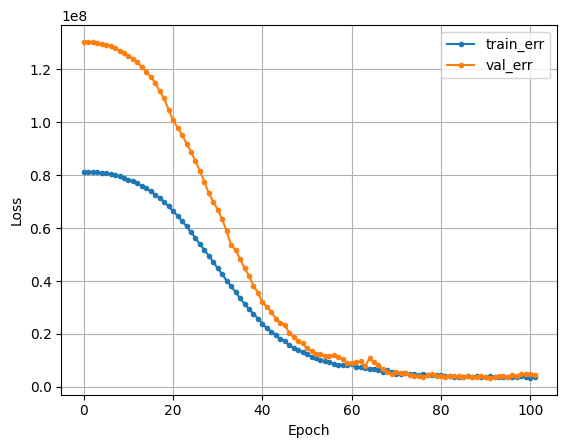

In [479]:
dl_history_plot(history)

In [480]:
y_pred = model.predict(x_test)

print('RMSE :', mean_squared_error(y_test, y_pred)**0.5)
print('MAE :', mean_absolute_error(y_test, y_pred))
print('MAPE :', mean_absolute_percentage_error(y_test, y_pred))
print('R2 Score :', r2_score(y_test, y_pred))

2/2 [==============================] - 0s 11ms/step
RMSE : 2686.5686298015835
MAE : 2189.313484700521
MAPE : 0.1817970649190345
R2 Score : 0.4730799353496715


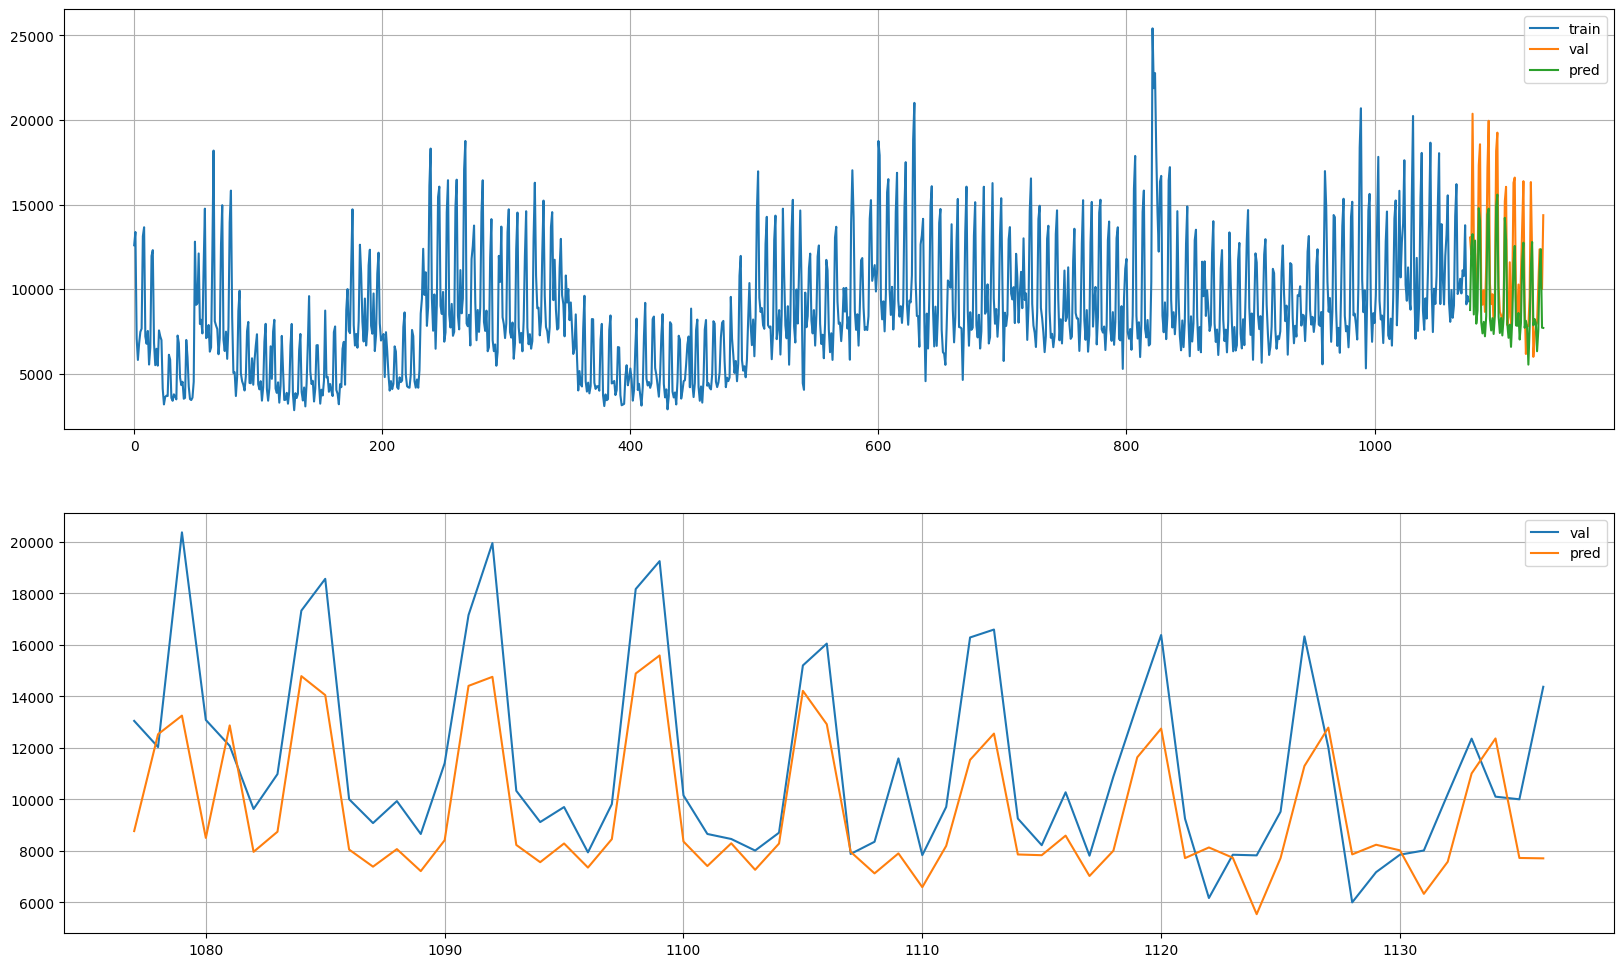

In [481]:
plot_model_result(y_train, y_test, y_pred)

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [482]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x[i:i+timesteps])
        output_y.append(y[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [483]:
x2, y2 = temporalize(X, y, 7)
x2.shape, y2.shape

((1131, 7, 23), (1131,))

In [484]:
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=60, shuffle=False)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1071, 7, 23), (60, 7, 23), (1071,), (60,))

* **모델링**

In [485]:
x_train[0].shape

(7, 23)

In [486]:
# LSTM
clear_session()

model = Sequential()
model.add(LSTM(200, input_shape=x_train[0].shape, return_sequences=False))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.summary()

model.compile(loss='mse', optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               179200    
                                                                 
 dense (Dense)               (None, 50)                10050     
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 189771 (741.29 KB)
Trainable params: 189771 (741.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [487]:
es = EarlyStopping(monitor='val_loss',
                   patience = 10,
                   min_delta = 0,
                   restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=300, validation_split=0.1, callbacks=[es]).history

Epoch 1/300
31/31 [==============================] - 5s 72ms/step - loss: 81231280.0000 - val_loss: 129762304.0000
Epoch 2/300
31/31 [==============================] - 1s 45ms/step - loss: 80358424.0000 - val_loss: 128186304.0000
Epoch 3/300
31/31 [==============================] - 1s 32ms/step - loss: 78714152.0000 - val_loss: 125262832.0000
Epoch 4/300
31/31 [==============================] - 1s 20ms/step - loss: 75835384.0000 - val_loss: 120367776.0000
Epoch 5/300
31/31 [==============================] - 1s 22ms/step - loss: 71285832.0000 - val_loss: 113011952.0000
Epoch 6/300
31/31 [==============================] - 1s 21ms/step - loss: 64888376.0000 - val_loss: 102936824.0000
Epoch 7/300
31/31 [==============================] - 1s 23ms/step - loss: 56680476.0000 - val_loss: 90546784.0000
Epoch 8/300
31/31 [==============================] - 1s 22ms/step - loss: 47247248.0000 - val_loss: 76167760.0000
Epoch 9/300
31/31 [==============================] - 1s 25ms/step - loss: 37214264

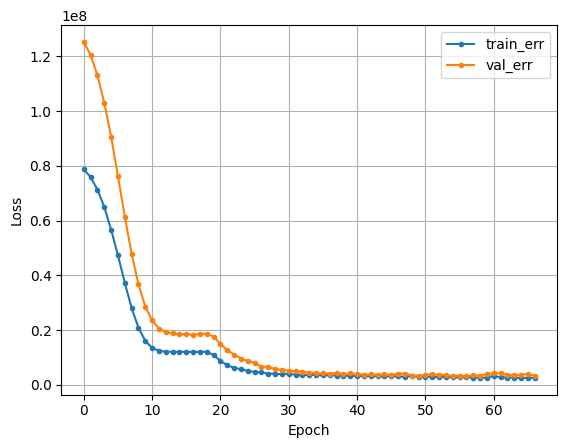

In [488]:
dl_history_plot(history)

In [489]:
y_pred = model.predict(x_test)
print('RMSE :', mean_squared_error(y_test, y_pred)**0.5)
print('MAE :', mean_absolute_error(y_test, y_pred))
print('MAPE :', mean_absolute_percentage_error(y_test, y_pred))
print('R2 Score :', r2_score(y_test, y_pred))


2/2 [==============================] - 1s 15ms/step
RMSE : 2884.535770728893
MAE : 2130.969580078125
MAPE : 0.17394734059302905
R2 Score : 0.3925637361178924


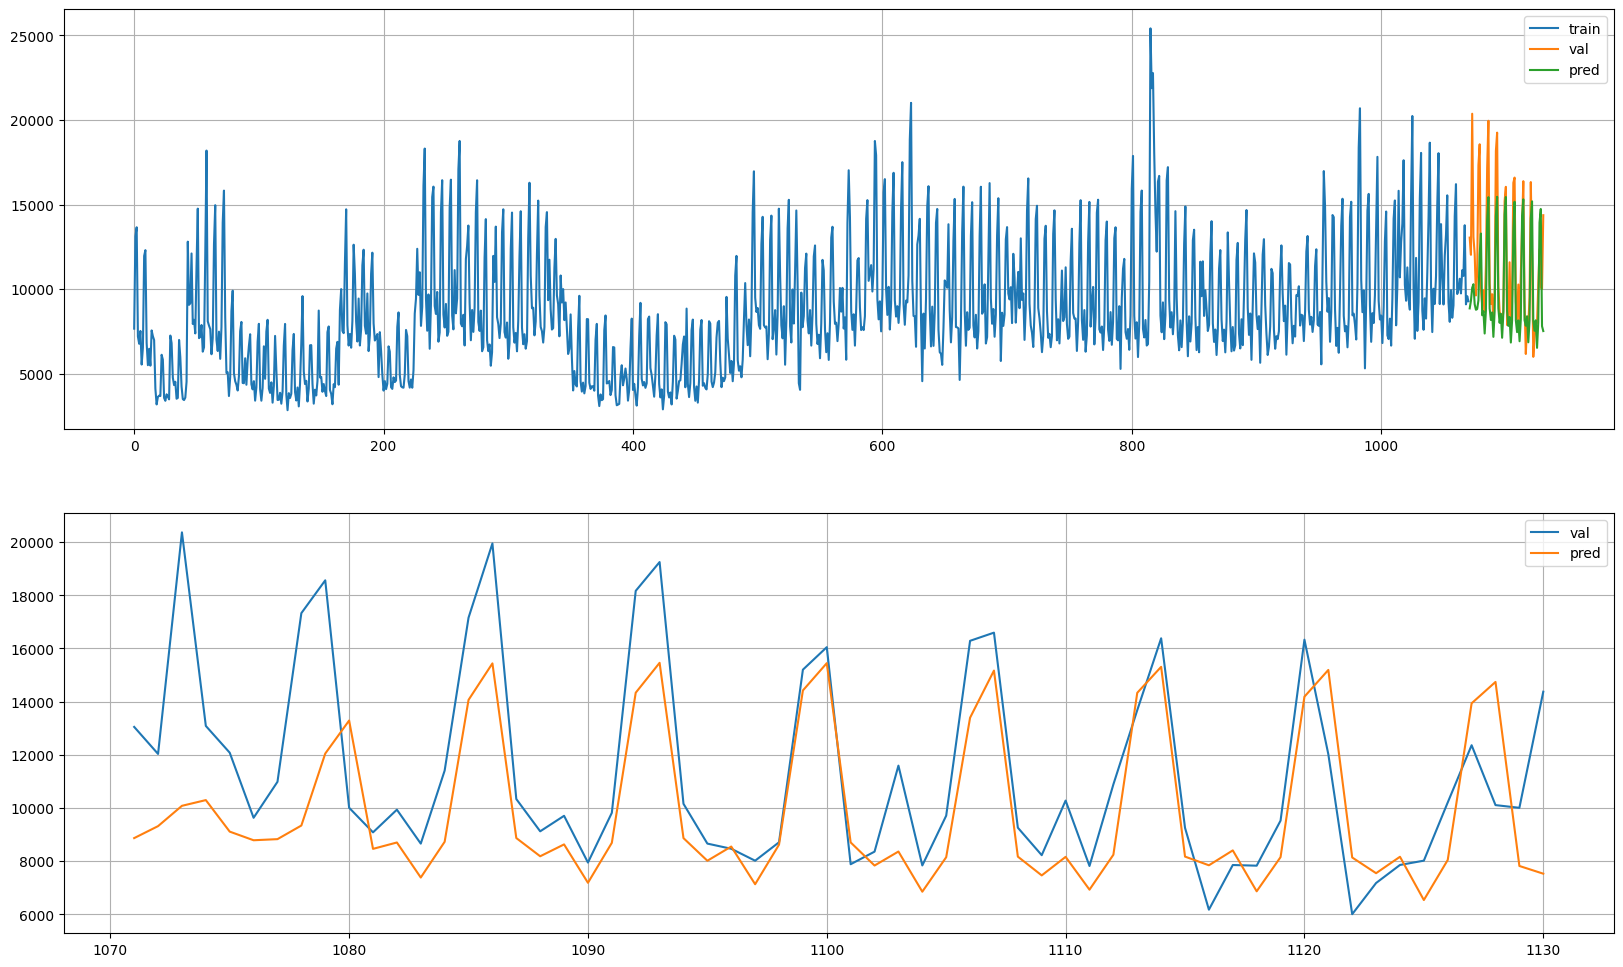

In [490]:
plot_model_result(y_train, y_test, y_pred)

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [491]:
x2, y2 = temporalize(X, y, 7)
x2.shape, y2.shape

((1131, 7, 23), (1131,))

In [492]:
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=60, shuffle=False)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1071, 7, 23), (60, 7, 23), (1071,), (60,))

* **모델링**

In [493]:
x_train[0].shape

(7, 23)

In [514]:
from keras.optimizers import Adam

clear_session()

model = Sequential()
model.add(Conv1D(filters=20, kernel_size=3, input_shape=x_train[0].shape, activation='relu', padding='same'))
# kernel_size는 행의 개수를 의미하고 1차원이므로 열을 자동으로 채워진다.
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

# 3*21*10 + 10 = parameter 개수
model.summary()

model.compile(loss='mse', optimizer=Adam(learning_rate=0.02))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 20)             1400      
                                                                 
 flatten (Flatten)           (None, 140)               0         
                                                                 
 dense (Dense)               (None, 10)                1410      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2821 (11.02 KB)
Trainable params: 2821 (11.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [515]:
es = EarlyStopping(monitor = 'val_loss',
                   patience = 15,
                   min_delta = 0,
                   restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=1000, validation_split=0.1, callbacks=[es]).history

Epoch 1/1000
31/31 [==============================] - 1s 10ms/step - loss: 68532024.0000 - val_loss: 51208464.0000
Epoch 2/1000
31/31 [==============================] - 0s 4ms/step - loss: 15369058.0000 - val_loss: 17950512.0000
Epoch 3/1000
31/31 [==============================] - 0s 5ms/step - loss: 10054214.0000 - val_loss: 12621158.0000
Epoch 4/1000
31/31 [==============================] - 0s 5ms/step - loss: 9115403.0000 - val_loss: 11239439.0000
Epoch 5/1000
31/31 [==============================] - 0s 6ms/step - loss: 8179587.0000 - val_loss: 10107589.0000
Epoch 6/1000
31/31 [==============================] - 0s 5ms/step - loss: 7287915.0000 - val_loss: 8901012.0000
Epoch 7/1000
31/31 [==============================] - 0s 4ms/step - loss: 6185968.0000 - val_loss: 7042187.5000
Epoch 8/1000
31/31 [==============================] - 0s 4ms/step - loss: 4945324.0000 - val_loss: 5468981.5000
Epoch 9/1000
31/31 [==============================] - 0s 6ms/step - loss: 4315115.5000 - val_lo

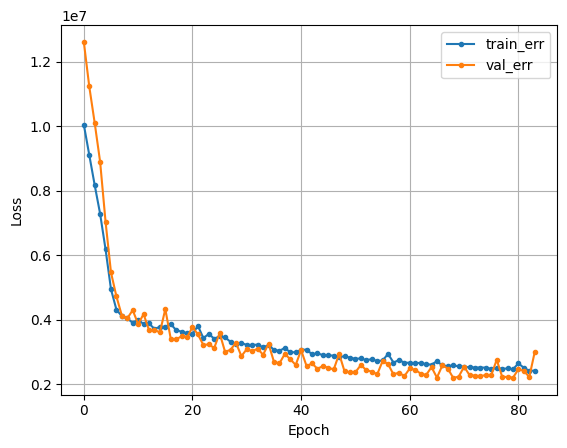

In [516]:
dl_history_plot(history)

In [517]:
y_pred = model.predict(x_test)
print('RMSE :', mean_squared_error(y_test, y_pred)**0.5)
print('MAE :', mean_absolute_error(y_test, y_pred))
print('MAPE :', mean_absolute_percentage_error(y_test, y_pred))
print('R2 Score :', r2_score(y_test, y_pred))

2/2 [==============================] - 0s 6ms/step
RMSE : 2197.671086015108
MAE : 1585.577482096354
MAPE : 0.13324512859145968
R2 Score : 0.647406544972007


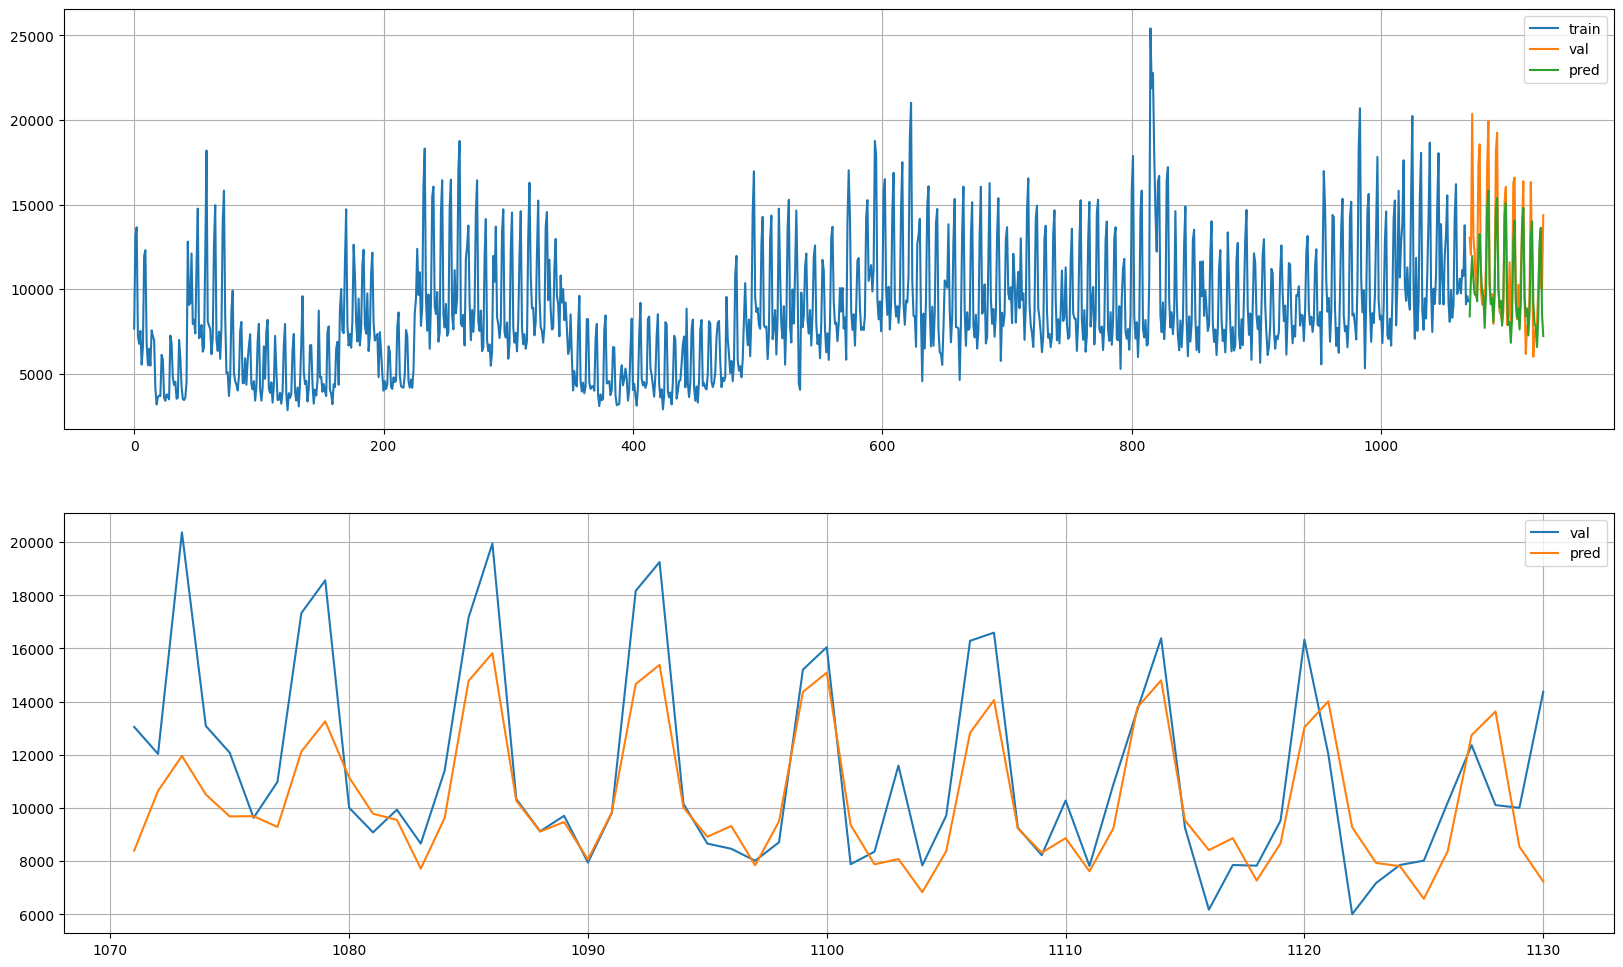

In [508]:
plot_model_result(y_train, y_test, y_pred)

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [509]:
joblib.dump(df ,path+'data.pkl')

['/content/drive/MyDrive/미니 프로젝트/시계열/data.pkl']